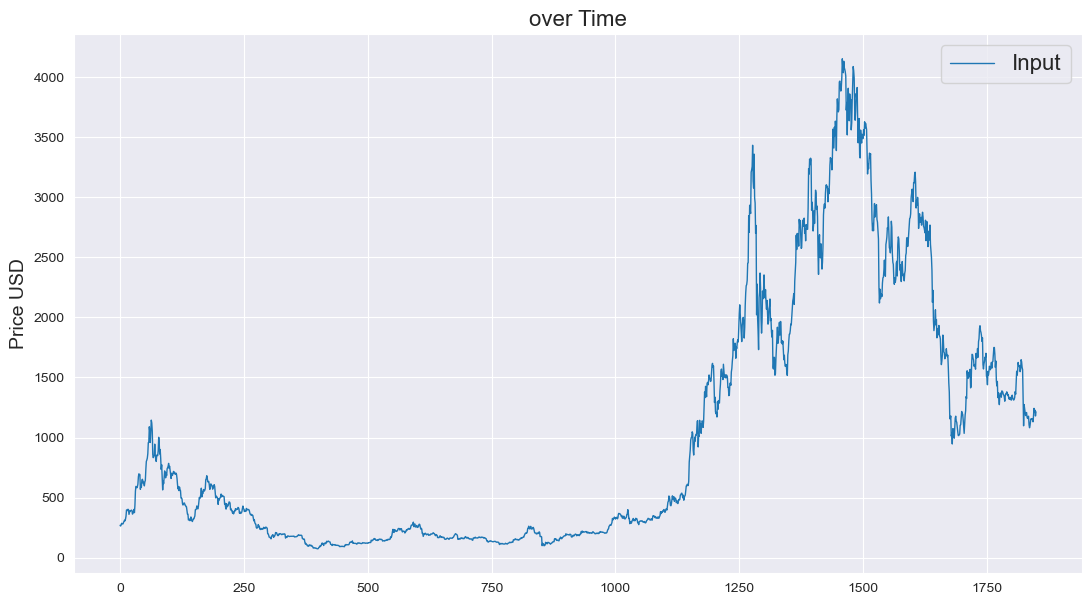

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Set the random seed for reproducibility
np.random.seed(42)

# Load the data
df = pd.read_csv('ETH-EUR_11_11_2017-07_12_2022.csv', usecols=[4], engine='python', skipfooter=3)

# # Plot the data
# plt.plot(df)
# plt.show()
#
# btc_trace = go.Scatter(x=df.index, y=df['Open'], name= 'Price')
# py.iplot([btc_trace])

fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df, label='Input', linewidth=1)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('over Time', fontsize=16)
ax.legend(loc='best', fontsize=16)


In [15]:

# Convert the data to a NumPy array
data = df.values
data = data.astype('float32')
df = data.copy()
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Split the data into training and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]


In [16]:

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [17]:

# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [18]:

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))


In [19]:

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=5, verbose=2)



Epoch 1/100
248/248 - 2s - loss: 0.0071 - 2s/epoch - 7ms/step
Epoch 2/100
248/248 - 0s - loss: 0.0043 - 235ms/epoch - 948us/step
Epoch 3/100
248/248 - 0s - loss: 0.0024 - 235ms/epoch - 948us/step
Epoch 4/100
248/248 - 0s - loss: 9.2323e-04 - 234ms/epoch - 944us/step
Epoch 5/100
248/248 - 0s - loss: 2.3843e-04 - 234ms/epoch - 944us/step
Epoch 6/100
248/248 - 0s - loss: 7.4717e-05 - 260ms/epoch - 1ms/step
Epoch 7/100
248/248 - 0s - loss: 5.5225e-05 - 250ms/epoch - 1ms/step
Epoch 8/100
248/248 - 0s - loss: 5.3283e-05 - 231ms/epoch - 931us/step
Epoch 9/100
248/248 - 0s - loss: 5.4511e-05 - 229ms/epoch - 923us/step
Epoch 10/100
248/248 - 0s - loss: 5.4551e-05 - 228ms/epoch - 919us/step
Epoch 11/100
248/248 - 0s - loss: 5.2682e-05 - 224ms/epoch - 903us/step
Epoch 12/100
248/248 - 0s - loss: 5.2978e-05 - 227ms/epoch - 915us/step
Epoch 13/100
248/248 - 0s - loss: 5.2519e-05 - 225ms/epoch - 907us/step
Epoch 14/100
248/248 - 0s - loss: 5.3269e-05 - 227ms/epoch - 915us/step
Epoch 15/100
248/248 -

In [20]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)



In [21]:

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


In [22]:

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 28.83 RMSE
Test Score: 195.89 RMSE


In [23]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict



In [24]:
# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(data)-1, :] = testPredict



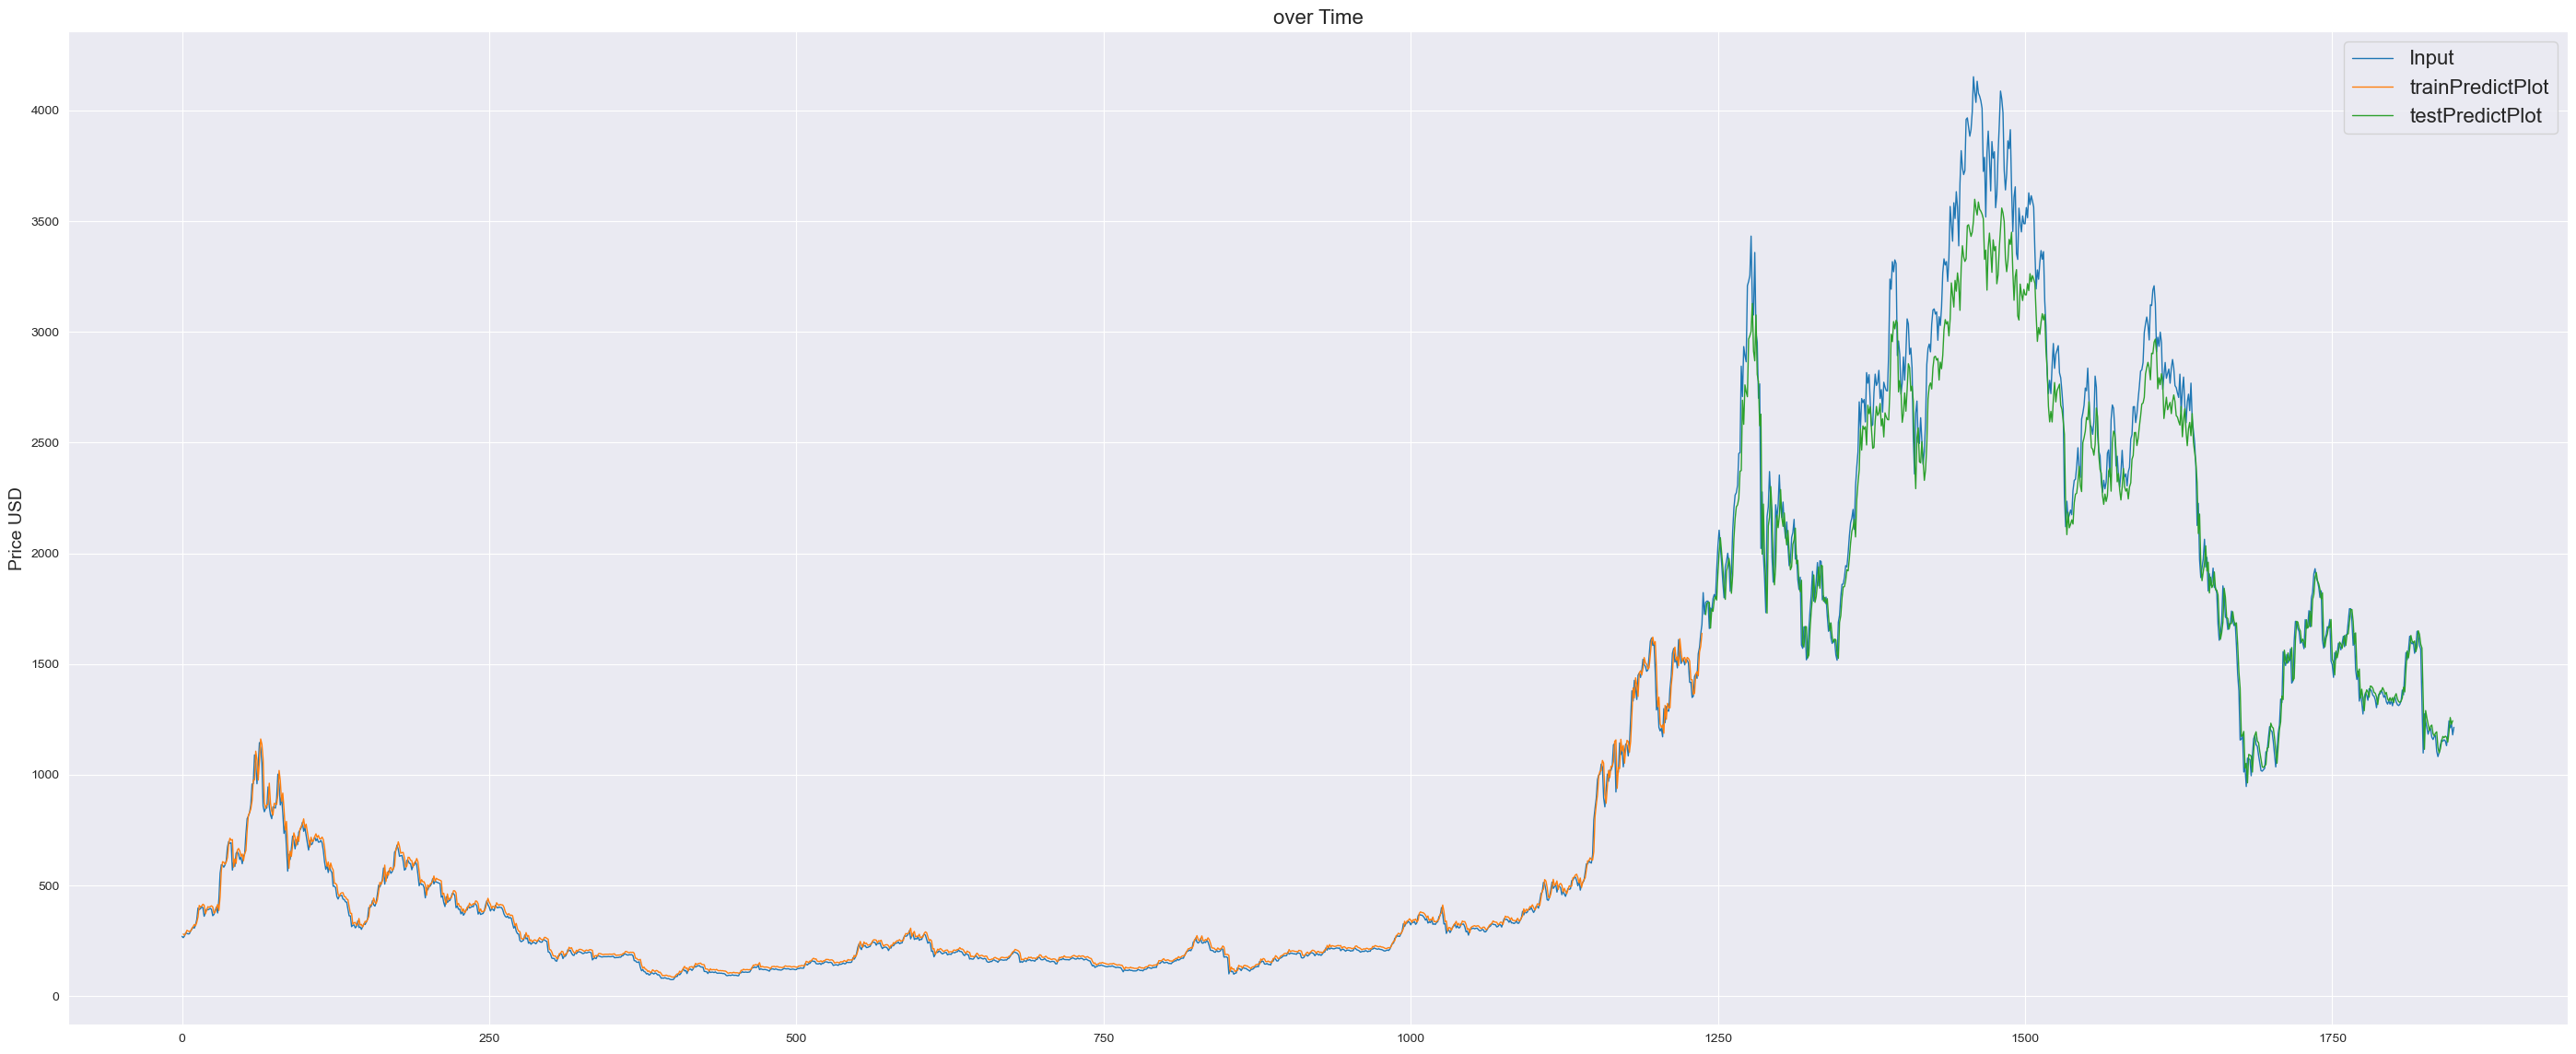

In [25]:
# # Plot baseline and predictions
# plt.plot(scaler.inverse_transform(data))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
#

fig, ax = plt.subplots(1, figsize=(35, 14))
ax.plot(scaler.inverse_transform(data), label='Input', linewidth=1)
ax.plot(trainPredictPlot, label='trainPredictPlot', linewidth=1)
ax.plot(testPredictPlot, label='testPredictPlot', linewidth=1)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('over Time', fontsize=16)
ax.legend(loc='best', fontsize=16)